# Imbalanced Classification: Oil Spill Classification

### Main techniques used:
* Scaling
* Normalization
* Probabilistic Models
* Data Sampling - SMOTE+ENN


### Background:
* The Oil Spill Classification dataset is an example of an imbalanced classification problem where a class label is required, and both positive and negative classes are equally important. (Detecting and acting on a spill is an expensive response, so false positives are bad. However it is also equally expensive and bad to miss an oil spill event.)
* The G-mean provides a way to evaluate imbalanced classification model in such a situation where Sensitivity and Specificity are both important metrics.

In [26]:
# Import necessary libraries

from matplotlib import pyplot
from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.dummy import DummyClassifier

### Simple EDA of the data

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


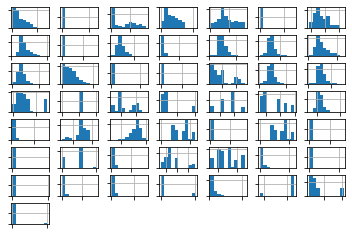

In [28]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

target = dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")
    
ax = dataframe.hist()
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

**Note:** We can see that the target class distribution is quite imbalanced.

**Note:** We can also see that there are many different distributions, and we expect that scaling and using power transforms may be useful, before proceeding to modelling.

### Evaluate a Baseline Model for reference

In [4]:
# Define a few custom functions

def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

# Evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [27]:
# define the location of the dataset
full_path = 'oil-spill.csv'

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='uniform')

# evaluate the model
scores = evaluate_model(X, y, model)

# summarize performance
# print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))
print(f"Mean G-Mean: {mean(scores):.3f} ({std(scores):.3f}%)")

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.437 (0.154%)


**Note:** Remember that Sensitivity is a measure of accuracy for the positive class, and Specificity is a measure of accuracy for the negative class. 

**Note:** G-mean seeks a balance of the sensitivity score + the specificity score. Poor performance for either will be penalized.

**Note:** We can see that the baseline algorithm achieves a G-mean of about 0.44. This score provides us with a lower limit on model skill. Any model that achieves an average G-mean of above 0.44 has skill, whereas models that achieve a score below this value do not have skill on this dataset.

### Evaluate Data Sampling methods + Probabilistic Models

We perform data sampling to better prepare the imbalanced training dataset prior to fitting a model.

* SMOTE is a popular oversampling technique for creating new synthetic examples for the minority class.
* The Edited Nearest Neighbor (ENN) algorithm locates and removes examples from the dataset that are ambigious, making it easier for models to learn to discriminate between the 2 classes.
* The imbalanced-learn library has a SMOTEENN class that allows us to put both techniques together.
* In addition, SMOTE and ENN both work better when the input data is scaled beforehand, as both techniques involve using the nearest neighbor algorithm internally, which is sensitive to input variables with different scales.

In [5]:
# Define the models that we want to test

def get_models():
    models, names = list(), list()
    # SMOTEENN
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('SMOTEENN+LR')
    # SMOTEENN + Normalization
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', MinMaxScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('SMOTEEN+Normalization')
    # SMOTEEN + Standardization
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', StandardScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('SMOTEENN+Standardization')
    # SMOTEENN + Normalization + Power Transform
    sampling = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('SMOTEENN+Norm+PowerTransform')
    return models, names

In [7]:
full_path = 'oil-spill.csv'

# Load the dataset
X, y = load_dataset(full_path)

# Define Models
models, names = get_models()

In [8]:
# Evaluate each model
results = list()

for i in range(len(models)):
    # Evaluate models and store results
    scores = evaluate_model(X, y, models[i])
    # Summarize and store the scores
    print(f"{names[i]} {mean(scores):.3f} ({std(scores):.3f})")
    results.append(scores)

SMOTEENN+LR 0.857 (0.103)
SMOTEEN+Normalization 0.838 (0.095)
SMOTEENN+Standardization 0.828 (0.132)
SMOTEENN+Norm+PowerTransform 0.882 (0.120)


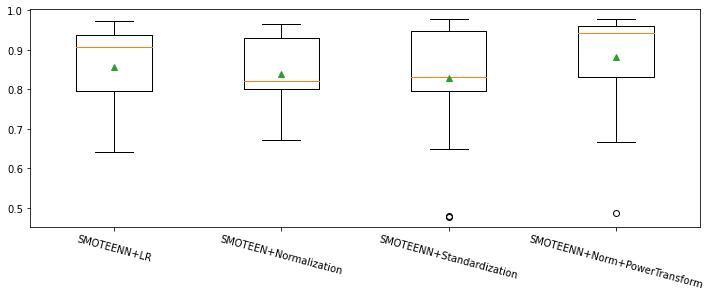

In [16]:
# Plot the results from above
pyplot.figure(figsize=(12,4))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=-15)
pyplot.show()

# Tip to adjust plot aesthetics to render X ticks properly
# https://www.programmersought.com/article/50984561968/

**Note:** Looking at the results, it seems that the combined techniques of: SMOTEENN + Normalization + Power Transforms + Logistic Regression provides the best G-mean score.

### Further steps:
* It is possible to further evaluate a group of different classifiers, and pick the 1 with the best potential.
* One can further tune the hyperparameters of the best performing model.
* Standard approaches such as GridSearchCV can be applied.